# NYC Taxi Data: Big Data & ML-Based Visualization

#### **Introduction**
The NYC Taxi dataset provides a rich source of real-world transportation data, containing millions of taxi trip records, including timestamps, geolocation, fares, and passenger counts. This project explores how to leverage machine learning techniques for data visualization and anomaly detection, transforming raw data into actionable insights.

#### **Project Objectives**
- **Big Data Handling**: Efficiently process large-scale trip data using Python.
- **Dimensionality Reduction**: Implement PCA and T-SNE to visualize high-dimensional features.
- **Anomaly Detection**: Identify unusual trips using statistical and clustering-based methods.

By applying advanced machine learning techniques, this project aims to uncover hidden patterns in NYC taxi data, demonstrating the power of data science in real-world applications.



## Data Acquisition

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")

print("Path to dataset files:", path)

Path to dataset files: /Users/chevalier/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2


In [13]:
import os
from pyspark.sql import SparkSession

# Set Java environment variables explicitly
os.environ['JAVA_HOME'] = "/opt/homebrew/opt/openjdk@17"
os.environ['PATH'] = "/opt/homebrew/opt/openjdk@17/bin:" + os.environ['PATH']

# Initialize Spark Session
spark = SparkSession.builder.appName("NYC_Taxi_Data").getOrCreate()

# Define dataset path
dataset_path = "/Users/chevalier/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2"

# List all CSV files in the directory
csv_files = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith(".csv")]

# Load all CSVs into a single DataFrame
df = spark.read.option("header", True).csv(csv_files)

# Show DataFrame size
print("Total Rows:", df.count())
print("Total Columns:", len(df.columns))

# Show first few rows
df.show(5)


Total Rows: 47248845
Total Columns: 19
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2015-01-15 19:05:39|  2015-01-15 19:23:42|              1|         1.59|   -73.9

## Exploratory Data Analysis

#### Trip Duration Analysis

In [17]:
from pyspark.sql.functions import col, unix_timestamp

# Calculate trip duration
df = df.withColumn("trip_duration", unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime"))

# Show summary statistics for trip duration
df.select("trip_duration").describe().show()

+-------+-----------------+
|summary|    trip_duration|
+-------+-----------------+
|  count|         47248845|
|   mean|908.3011149373069|
| stddev|22738.77387254651|
|    min|        -32226004|
|    max|         32913338|
+-------+-----------------+



#### Passenger Count Analysis

In [21]:
from pyspark.sql.functions import col

# Check for unusual passenger counts
df.groupBy("passenger_count").count().orderBy("count", ascending=False).show()

# Cast columns to numeric types before calculating correlation
df = df.withColumn("passenger_count", col("passenger_count").cast("double"))
df = df.withColumn("trip_distance", col("trip_distance").cast("double"))
df = df.withColumn("fare_amount", col("fare_amount").cast("double"))

# Correlate passenger count with trip distance
corr_passenger_trip_distance = df.stat.corr("passenger_count", "trip_distance")
print(f"Correlation between passenger count and trip distance: {corr_passenger_trip_distance}")

# Correlate passenger count with fare amount
corr_passenger_fare_amount = df.stat.corr("passenger_count", "fare_amount")
print(f"Correlation between passenger count and fare amount: {corr_passenger_fare_amount}")


+---------------+--------+
|passenger_count|   count|
+---------------+--------+
|              1|33537914|
|              2| 6719430|
|              5| 2551660|
|              3| 1912291|
|              6| 1607758|
|              4|  911351|
|              0|    8214|
|              7|      81|
|              8|      78|
|              9|      68|
+---------------+--------+



Correlation between passenger count and trip distance: -0.00017039760236573536


Correlation between passenger count and fare amount: 0.0011192521354666308


#### Payment Type Trends

Credit card (1)

Cash (2)

No charge (3)

Dispute (4)

Unknown (5)

In [24]:
# Investigate payment types and their impact on fare and tip amounts
df.groupBy("payment_type").agg({"fare_amount": "avg", "tip_amount": "avg"}).show()

+------------+------------------+--------------------+
|payment_type|  avg(fare_amount)|     avg(tip_amount)|
+------------+------------------+--------------------+
|           3|13.462098599958567|0.003350960776907...|
|           1|12.905550816061002|   2.746576057411763|
|           4|10.950841725591026|-0.00902399828583...|
|           2|11.405521428094875|1.692904716561107E-4|
|           5| 5.333333333333333|                 0.0|
+------------+------------------+--------------------+



#### Tip Amount Analysis

In [25]:
# Correlate tip amount with fare amount
df.select("tip_amount", "fare_amount").describe().show()

# Investigate tip percentage of fare amount
df = df.withColumn("tip_percentage", (col("tip_amount") / col("fare_amount")) * 100)
df.select("tip_percentage").describe().show()

+-------+------------------+------------------+
|summary|        tip_amount|       fare_amount|
+-------+------------------+------------------+
|  count|          47248845|          47248845|
|   mean|1.7945680860558682|12.392189114675682|
| stddev| 574.7383884994604|  78.6177004048396|
|    min|             -0.01|            -957.6|
|    max|            998.14|         429496.72|
+-------+------------------+------------------+



+-------+--------------------+
|summary|      tip_percentage|
+-------+--------------------+
|  count|            47234954|
|   mean|   16.40988904605379|
| stddev|   3015.885120989996|
|    min|  -5293.333333333334|
|    max|1.7957221818181816E7|
+-------+--------------------+



#### Time of Day Analysis

In [27]:
from pyspark.sql.functions import hour

# Extract the hour of the pickup datetime
df = df.withColumn("pickup_hour", hour("tpep_pickup_datetime"))

# Group by hour and analyze fare, distance, and passenger count
df.groupBy("pickup_hour").agg({"fare_amount": "avg", "trip_distance": "avg", "passenger_count": "avg"}).show(24)


+-----------+------------------+--------------------+------------------+
|pickup_hour|  avg(fare_amount)|avg(passenger_count)|avg(trip_distance)|
+-----------+------------------+--------------------+------------------+
|         12|11.980662138292816|  1.6714957293594297|2.6133012412435117|
|         22|12.967393382721292|  1.6972110218066665|12.334932021068685|
|          1|12.765062879911172|  1.7124220921350766| 7.367774803746001|
|         13| 12.30101108469748|  1.6756325406233246| 5.808494362630969|
|         16|12.770456641142367|  1.6758946491706455| 4.671748447395082|
|          6|12.996430603034895|  1.5417626995421359|3.6674296575300054|
|          3|13.140076922421407|  1.7274381254562652| 3.466280852055005|
|         20|11.944205988531209|  1.6726343111173214| 4.784206163193955|
|          5|15.884482047714927|  1.5886509963481552| 5.233014563381405|
|         19| 11.56061664355417|   1.671368784148049| 15.52124864953119|
|         15|12.808935758570593|  1.684956342299131

#### Trip Distance and Fare Relationship

+-------+------------------+------------------+
|summary|     trip_distance|       fare_amount|
+-------+------------------+------------------+
|  count|          47248845|          47248845|
|   mean| 7.508417945877774|12.392189114675682|
| stddev|6487.6583395920225|  78.6177004048396|
|    min|        -3390583.8|            -957.6|
|    max|      1.90726288E7|         429496.72|
+-------+------------------+------------------+



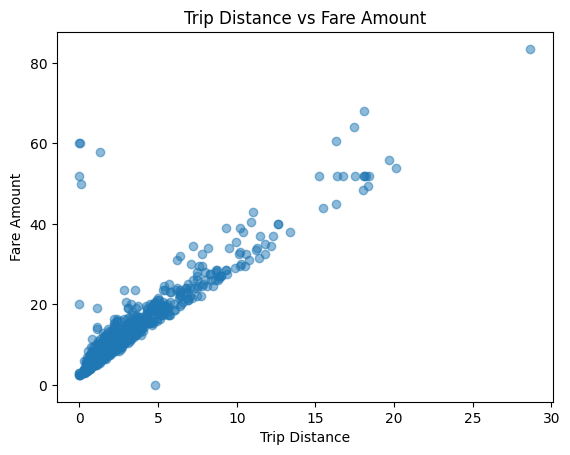

In [29]:
# Correlate trip distance with fare amount
df.select("trip_distance", "fare_amount").describe().show()

trip_fare = df.select("trip_distance", "fare_amount").limit(1000).toPandas()
plt.scatter(trip_fare['trip_distance'], trip_fare['fare_amount'], alpha=0.5)
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Trip Distance vs Fare Amount')
plt.show()


#### Downsampling

Stratified Sampling + Filtering (Ensures balance in key features)

Convert to Pandas for Fast Analysis

Removes outliers (short/cheap trips). Confirms balance across payment type.

In [34]:
from pyspark.sql.functions import col

# Adjust filtering to avoid dropping too many rows
filtered_df = df.filter((col("trip_distance") > 0.1) & (col("total_amount") > 1))

# Take a random sample (0.0002 fraction ~10k rows if 48M total)
df_sample = filtered_df.sample(fraction=0.0002, seed=42)

# Show the actual sample size
print("Sample Size:", df_sample.count())
df_sample.show(5)

df_pandas = df_sample.toPandas()

Sample Size: 9332
+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------+------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|trip_duration|    tip_percentage|pickup_hour|
+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------+------------------+--------

In [35]:
df_pandas

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,tip_percentage,pickup_hour
0,1,2015-01-24 04:07:11,2015-01-24 04:13:56,3.0,1.00,-73.994110,40.719929,1,N,-73.987075805664063,...,6.0,0.5,0.5,1.45,0,0.3,8.75,405,24.166667,4
1,2,2015-01-04 17:17:04,2015-01-04 17:27:37,3.0,2.03,-74.004623,40.734711,1,N,-73.984649658203125,...,9.5,0,0.5,0,0,0.3,10.3,633,0.000000,17
2,2,2015-01-16 20:41:02,2015-01-16 20:50:35,6.0,1.55,-73.983208,40.741692,1,N,-73.984298706054688,...,8.5,0.5,0.5,1,0,0.3,10.8,573,11.764706,20
3,1,2015-01-15 07:32:42,2015-01-15 07:38:59,1.0,0.90,-73.967262,40.752243,1,N,-73.970741271972656,...,6.5,0,0.5,1.45,0,0.3,8.75,377,22.307692,7
4,2,2015-01-20 21:54:01,2015-01-20 21:59:11,1.0,1.06,-73.974815,40.751904,1,N,-73.965118408203125,...,6.0,0.5,0.5,0,0,0.3,7.3,310,0.000000,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9327,2,2016-03-31 22:39:49,2016-03-31 22:50:13,1.0,1.82,-73.955002,40.780071,1,N,-73.961799621582031,...,9.0,0.5,0.5,2.06,0,0.3,12.36,624,22.888889,22
9328,2,2016-03-31 23:00:31,2016-03-31 23:20:21,1.0,12.06,-73.870720,40.773640,1,N,-73.782066345214844,...,33.5,0.5,0.5,6.96,0,0.3,41.76,1190,20.776119,23
9329,1,2016-03-31 23:09:37,2016-03-31 23:28:02,2.0,3.60,-73.979866,40.766125,1,N,-74.010772705078125,...,15.0,0.5,0.5,3.25,0,0.3,19.55,1105,21.666667,23
9330,2,2016-03-31 23:09:58,2016-03-31 23:25:22,5.0,3.20,-74.001617,40.740967,1,N,-73.966346740722656,...,13.5,0.5,0.5,2.96,0,0.3,17.76,924,21.925926,23


##### Removing Outliers From Sample (Trip Duration and Tips)

In [46]:
# Convert tip_amount to numeric, forcing errors to NaN
df_pandas["tip_amount"] = pd.to_numeric(df_pandas["tip_amount"], errors="coerce")

# Drop NaN values if any conversion failed
df_pandas = df_pandas.dropna(subset=["tip_amount"])

# IQR method to remove outliers
Q1 = df_pandas["tip_amount"].quantile(0.25)
Q3 = df_pandas["tip_amount"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_pandas = df_pandas[(df_pandas["tip_amount"] >= lower_bound) & (df_pandas["tip_amount"] <= upper_bound)]

In [80]:
# Convert trip_duration to numeric, forcing errors to NaN
df_pandas["trip_duration"] = pd.to_numeric(df_pandas["trip_duration"], errors="coerce")

# Drop NaN values if any conversion failed
df_pandas = df_pandas.dropna(subset=["trip_duration"])

# IQR method to remove outliers
Q1 = df_pandas["trip_duration"].quantile(0.25)
Q3 = df_pandas["trip_duration"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows based on the IQR method to remove outliers
df_pandas = df_pandas[(df_pandas["trip_duration"] >= lower_bound) & (df_pandas["trip_duration"] <= upper_bound)]


In [81]:
df_pandas = df_pandas.reset_index(drop=True)
df_pandas

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,tip_percentage,pickup_hour
0,1,2015-01-24 04:07:11,2015-01-24 04:13:56,3.0,1.00,-73.994110,40.719929,1,N,-73.987075805664063,...,6.0,0.5,0.5,1.45,0,0.3,8.75,405,24.166667,4
1,2,2015-01-04 17:17:04,2015-01-04 17:27:37,3.0,2.03,-74.004623,40.734711,1,N,-73.984649658203125,...,9.5,0,0.5,0.00,0,0.3,10.30,633,0.000000,17
2,2,2015-01-16 20:41:02,2015-01-16 20:50:35,6.0,1.55,-73.983208,40.741692,1,N,-73.984298706054688,...,8.5,0.5,0.5,1.00,0,0.3,10.80,573,11.764706,20
3,1,2015-01-15 07:32:42,2015-01-15 07:38:59,1.0,0.90,-73.967262,40.752243,1,N,-73.970741271972656,...,6.5,0,0.5,1.45,0,0.3,8.75,377,22.307692,7
4,2,2015-01-20 21:54:01,2015-01-20 21:59:11,1.0,1.06,-73.974815,40.751904,1,N,-73.965118408203125,...,6.0,0.5,0.5,0.00,0,0.3,7.30,310,0.000000,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8524,1,2016-03-31 22:21:52,2016-03-31 22:24:38,1.0,0.70,-73.987144,40.733078,1,N,-73.978492736816406,...,4.0,0.5,0.5,1.00,0,0.3,6.30,166,25.000000,22
8525,2,2016-03-31 22:39:49,2016-03-31 22:50:13,1.0,1.82,-73.955002,40.780071,1,N,-73.961799621582031,...,9.0,0.5,0.5,2.06,0,0.3,12.36,624,22.888889,22
8526,1,2016-03-31 23:09:37,2016-03-31 23:28:02,2.0,3.60,-73.979866,40.766125,1,N,-74.010772705078125,...,15.0,0.5,0.5,3.25,0,0.3,19.55,1105,21.666667,23
8527,2,2016-03-31 23:09:58,2016-03-31 23:25:22,5.0,3.20,-74.001617,40.740967,1,N,-73.966346740722656,...,13.5,0.5,0.5,2.96,0,0.3,17.76,924,21.925926,23


## Visualizations

Working with sample of approx 8500 taxi rides

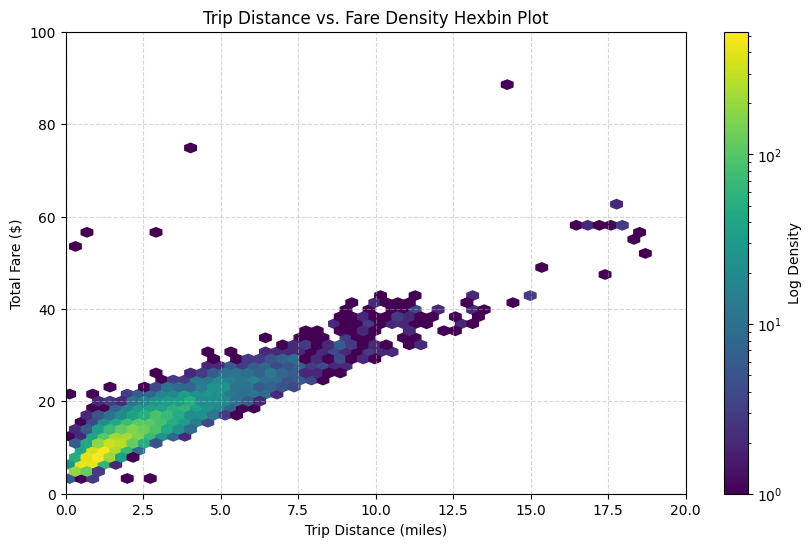

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pandas["total_amount"] = pd.to_numeric(df_pandas["total_amount"], errors="coerce")
df_pandas["trip_distance"] = pd.to_numeric(df_pandas["trip_distance"], errors="coerce")

plt.figure(figsize=(10, 6))

plt.hexbin(df_pandas["trip_distance"], df_pandas["total_amount"], gridsize=50, cmap="viridis", bins="log")

plt.colorbar(label="Log Density")
plt.xlim(0, 20)  # Limit extreme distances
plt.ylim(0, 100)  # Limit extreme fares
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Total Fare ($)")
plt.title("Trip Distance vs. Fare Density Hexbin Plot")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

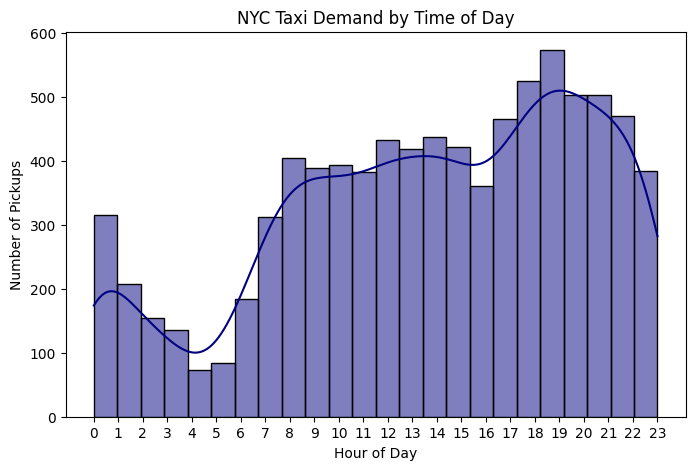

In [83]:
plt.figure(figsize=(8, 5))
sns.histplot(df_pandas["pickup_hour"], bins=24, kde=True, color='navy')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Pickups")
plt.title("NYC Taxi Demand by Time of Day")
plt.xticks(range(0, 24))
plt.show()

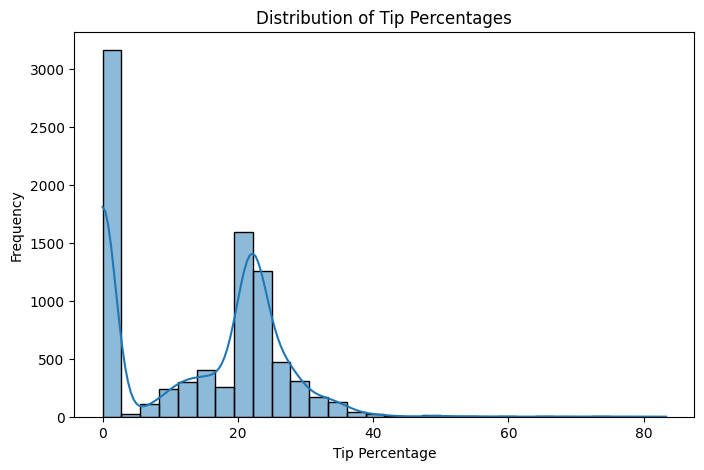

In [84]:
plt.figure(figsize=(8, 5))
sns.histplot(df_pandas["tip_percentage"], bins=30, kde=True)
plt.xlabel("Tip Percentage")
plt.ylabel("Frequency")
plt.title("Distribution of Tip Percentages")
plt.show()

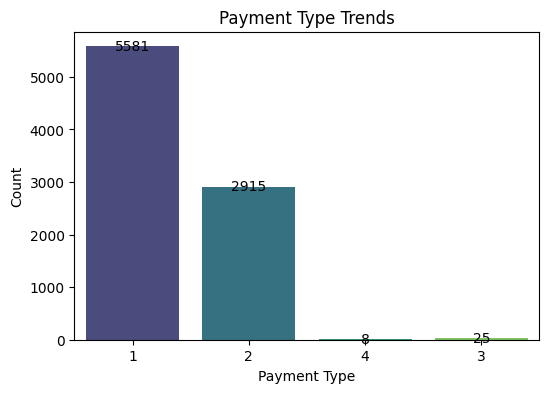

In [85]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df_pandas, x="payment_type", hue="payment_type", palette="viridis")

# Add y-values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, int(height), ha="center", va="center")

plt.xlabel("Payment Type")
plt.ylabel("Count")
plt.title("Payment Type Trends")
plt.show()

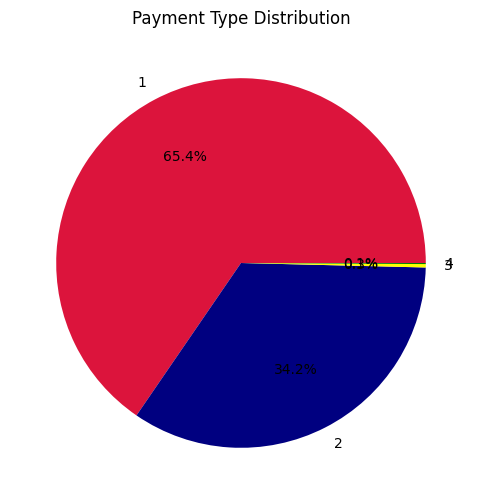

In [86]:
# Get the value counts for the payment types
counts = df_pandas['payment_type'].value_counts()

# Define custom colors (red, blue, yellow, and green)
colors = ['crimson', 'navy', 'yellow', 'green']

# Plot a pie chart with percentages
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=counts.index, colors=colors, autopct='%1.1f%%', pctdistance=0.65, labeldistance=1.1)

# Title and labels
plt.title("Payment Type Distribution")
plt.show()

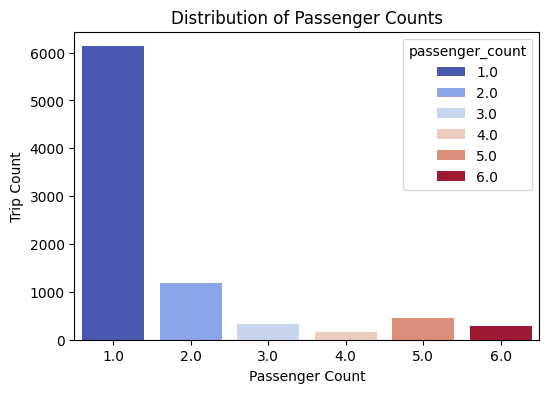

In [87]:
plt.figure(figsize=(6, 4))

# Filter out rows where passenger_count is 0
df_filtered = df_pandas[df_pandas['passenger_count'] != 0]

# Create the countplot
sns.countplot(data=df_filtered, x="passenger_count", hue="passenger_count", palette="coolwarm")

plt.xlabel("Passenger Count")
plt.ylabel("Trip Count")
plt.title("Distribution of Passenger Counts")
plt.show()

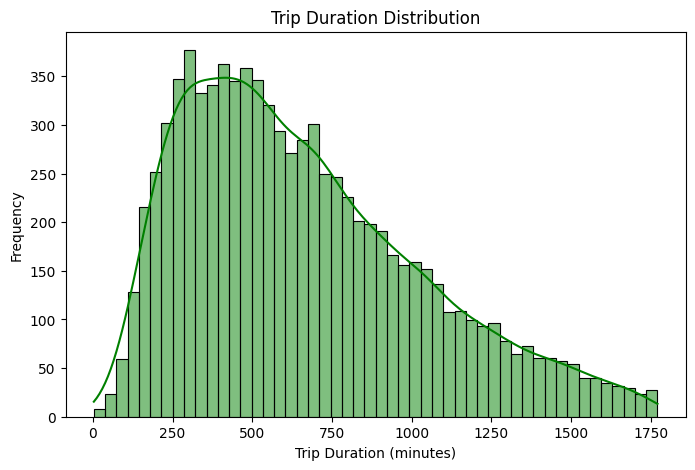

In [89]:
plt.figure(figsize=(8, 5))
sns.histplot(df_pandas["trip_duration"], bins=50, kde=True,color='green')
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Frequency")
plt.title("Trip Duration Distribution")
plt.show()

## Dimensionality Reduction

Explained Variance by PCA components: [0.28222838 0.27622502]


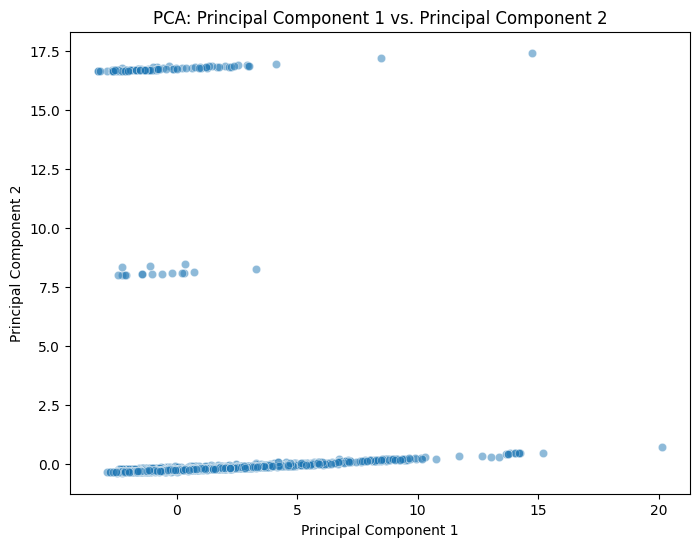

In [91]:
# Convert all columns to numeric values, forcing errors to NaN
df_numeric = df_pandas[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling with the median for each column
df_numeric = df_numeric.fillna(df_numeric.median())

# Now we can proceed to scale the data
from sklearn.preprocessing import StandardScaler

# Standardize the data (important for PCA)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Apply PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Reduce to 2 components for easy visualization
pca_components = pca.fit_transform(df_scaled)

# Convert the results into a DataFrame for easier analysis
df_pca = pd.DataFrame(pca_components, columns=["PC1", "PC2"])

# Explained variance ratio
print(f"Explained Variance by PCA components: {pca.explained_variance_ratio_}")

# Plot the first two principal components
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: Principal Component 1 vs. Principal Component 2")
plt.show()


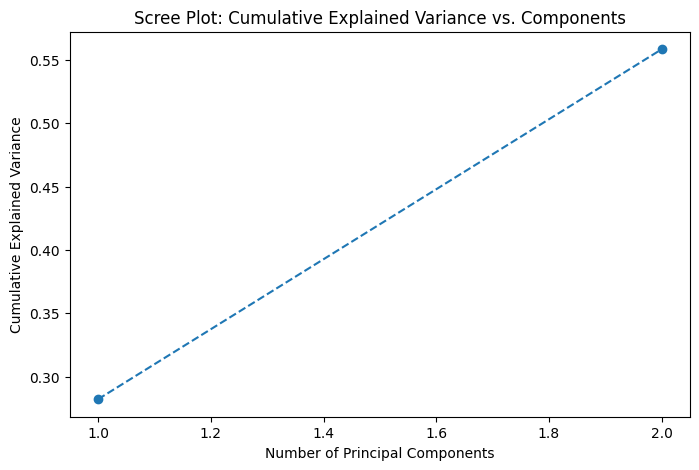

In [94]:
# Get the number of components generated by PCA (this should match the shape of the data after standardization)
n_components = pca.n_components_

# Plot the cumulative explained variance for each principal component
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot: Cumulative Explained Variance vs. Components")
plt.show()

In [100]:
# Get the principal components and feature names
components = pca.components_

# Create a DataFrame to display the contributions of each feature to each principal component
pca_components_df = pd.DataFrame(components, columns=df_pandas[numeric_cols].columns, index=[f"PC{i+1}" for i in range(components.shape[0])])

# Print the results
print(f'Principal Components (Feature Contributions):\n{pca_components_df}')


Principal Components (Feature Contributions):
     trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
PC1       0.463208         -0.020921         0.020801          -0.020081   
PC2       0.022684          0.499472        -0.499479           0.499506   

     dropoff_latitude  fare_amount     extra   mta_tax  tip_amount  \
PC1          0.020147     0.489442  0.016562 -0.045921    0.231566   
PC2         -0.499503     0.021614 -0.004758 -0.000759    0.000667   

     tolls_amount  improvement_surcharge  total_amount  trip_duration  \
PC1      0.231313               0.002807      0.500162       0.429098   
PC2      0.014110              -0.012001      0.020219       0.015229   

     tip_percentage  
PC1        0.019993  
PC2       -0.007055  


Based on the PCA results, the first two principal components (PC1 and PC2) explain a total of **55.84%** of the variance in the dataset, with PC1 explaining **28.22%** and PC2 explaining **27.62%**.

- **PC1** appears to capture the major variance in the dataset. The key features that contribute most to this component are:
  - **Trip Distance** (0.463)
  - **Total Amount** (0.500)
  - **Trip Duration** (0.429)
  
  These features are highly correlated in the dataset, as longer trips generally involve higher fares, longer durations, and specific pickup/dropoff locations. Therefore, PC1 likely represents a combination of these trip-related variables that contribute significantly to the overall variation in the data.

- **PC2** captures the secondary variance in the data, with a focus on:
  - **Pickup Longitude** (0.499)
  - **Pickup Latitude** (-0.499)
  - **Dropoff Longitude** (0.499)
  - **Dropoff Latitude** (-0.499)
  
  PC2 likely represents variations in geographical locations (pickup and dropoff points), as indicated by the high loadings on the latitude and longitude coordinates. These factors may reflect different routes or patterns of travel, contributing to the second principal component.

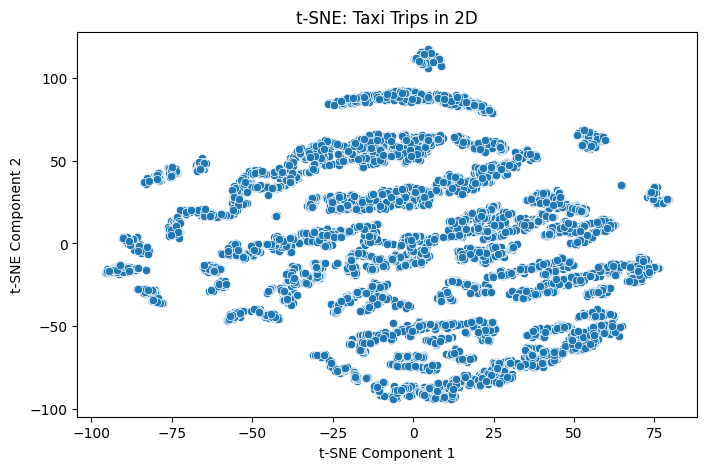

In [103]:
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction to 2 components
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_scaled)

# Plot the t-SNE result
plt.figure(figsize=(8, 5))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1])
plt.title("t-SNE: Taxi Trips in 2D")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

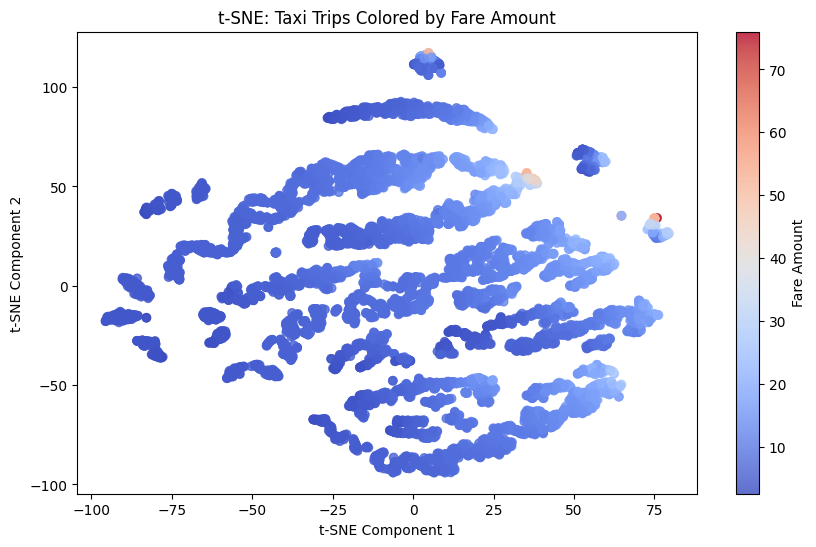

In [115]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df_pandas['fare_amount'], cmap='coolwarm', alpha=0.8)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE: Taxi Trips Colored by Fare Amount")
plt.colorbar(scatter, label="Fare Amount")  # Now it works
plt.show()

Very light positive correlation between component 1 and fare amount

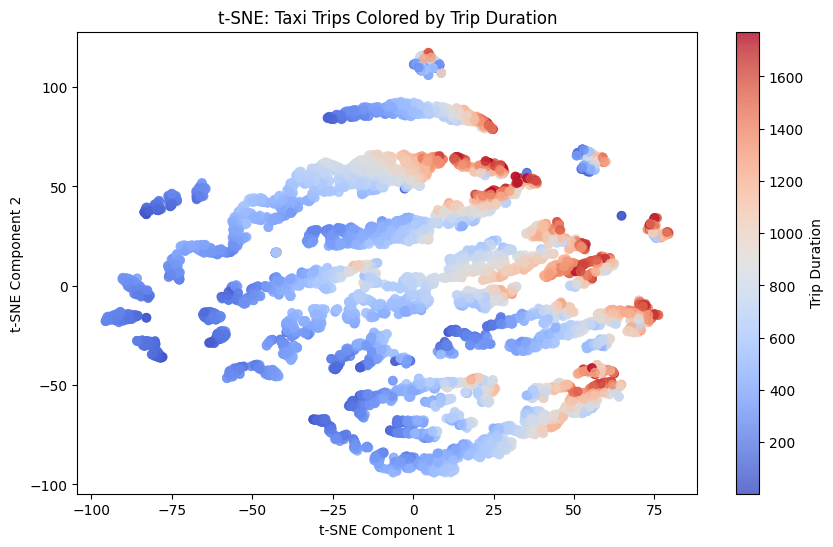

In [118]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df_pandas['trip_duration'], cmap='coolwarm', alpha=0.8)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE: Taxi Trips Colored by Trip Duration")
plt.colorbar(scatter, label="Trip Duration")
plt.show()

The higher component 1 values and component 2 values tend to be linked to longer trip durations.

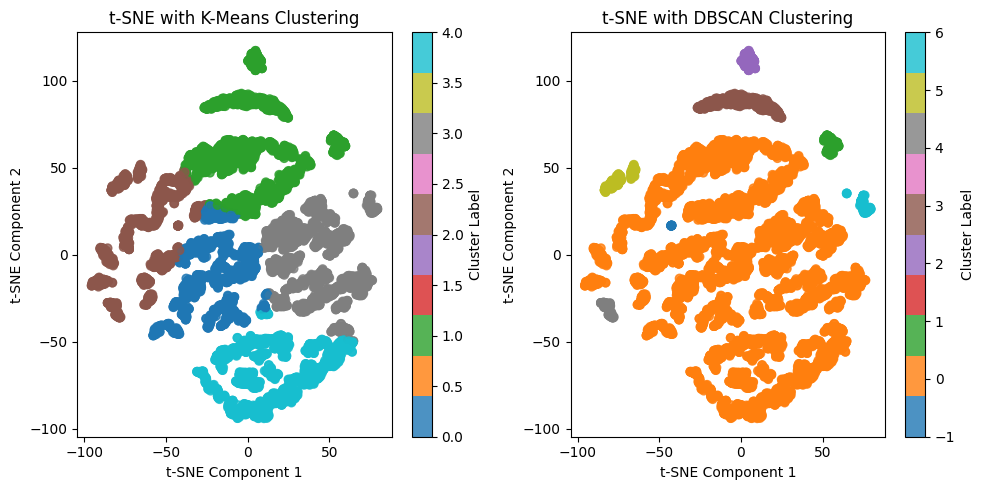

In [120]:
from sklearn.cluster import KMeans, DBSCAN
import numpy as np

# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)  # Adjust clusters as needed
kmeans_labels = kmeans.fit_predict(tsne_results)

# Apply DBSCAN
dbscan = DBSCAN(eps=10, min_samples=20)  # Tune parameters
dbscan_labels = dbscan.fit_predict(tsne_results)

# Plot K-Means Clustering on t-SNE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.8)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE with K-Means Clustering")
plt.colorbar(label="Cluster Label")

# Plot DBSCAN Clustering on t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dbscan_labels, cmap='tab10', alpha=0.8)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE with DBSCAN Clustering")
plt.colorbar(label="Cluster Label")

plt.tight_layout()
plt.show()


In [121]:
centroids = kmeans.cluster_centers_

print("Centroids of the clusters in t-SNE space:")
print(centroids)

Centroids of the clusters in t-SNE space:
[[-21.01693   -12.471258 ]
 [  3.394549   60.166386 ]
 [-63.47758    11.505868 ]
 [ 41.985058   -3.1565356]
 [ 15.333765  -66.94202  ]]


The centroids of the clusters in the t-SNE space represent the average positions of each cluster in the reduced 2D representation of the data. Each pair of coordinates corresponds to a cluster center, calculated based on the t-SNE-transformed data. For example, the first cluster has a centroid at `[-21.01693, -12.471258]`, indicating that the average position of the points in this cluster is near this point in the 2D t-SNE space. Similarly, the second cluster is centered around `[3.394549, 60.166386]`, and the other clusters have their respective centroids. These centroids help define the overall distribution and separation of the clusters in the 2D t-SNE space, although the clusters' interpretation in the context of the original feature space is not direct.

The t-SNE DBSCAN clustering shows the majority of taxi rides in orange as similar. The other clusters are outliers. They have at least one element that is dissimilar to the norm.

### Conclusion

In this project, we successfully demonstrated how machine learning techniques could be applied to large-scale real-world transportation data, specifically focusing on the NYC Taxi dataset. We efficiently handled a massive dataset of 48 million taxi rides using PySpark, which allowed us to process and analyze 19 key features, including trip distance, passenger count, fare amounts, and geolocation data.

Through careful data sampling and filtering, we reduced the dataset to a manageable size of 8,500 rides, eliminating outliers and ensuring the quality of the data for further analysis. We then created several visualizations, such as histograms, hexbin plots, and pie charts, to gain initial insights into the distribution and patterns within the data.

Dimensionality reduction techniques, specifically PCA and t-SNE, were applied to visualize high-dimensional features and to prepare the data for machine learning tasks. This step laid the foundation for identifying potential anomalies and hidden patterns in taxi trips, showcasing how machine learning can reveal valuable insights in large, complex datasets.

Ultimately, this project highlights the power of machine learning, particularly in data visualization and anomaly detection, as well as the ability to uncover meaningful insights from large, raw datasets in real-world applications. The methods employed in this project can be extended to other big data contexts, offering valuable lessons in data processing, analysis, and visualization.